## Setting Up the Libs and Overthrust Configurations

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dx1        = 30.0                  # step interval along y/z direction

dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) Overthrust
ny        = 400                   # model shape of y dimension Overthrust
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 567        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx1 * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lr            = 80        # learning rate for updating the model.
fwi_batch         =   30      # number of batches for FWI.
fwi_num_epochs    = 600       # number of FWI iteration.
sim_lr            = 1*1e-4    # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


/home/sadalyom/.conda/envs/FWIGAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
receiver_spacing/100, source_spacing/1000

(0.21, 0.387)

##   Check Cuda Device 


In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes

In [4]:
 
data_path = 'data/over_94_400.bin'
initfile = 'data/over_initmodel.mat'
initsafile = 'data/over_initsource.mat'
fwi_result = 'results/overthrust/'
# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
model, model_init = loadinitmodel(initfile,device)
# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
x_s, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


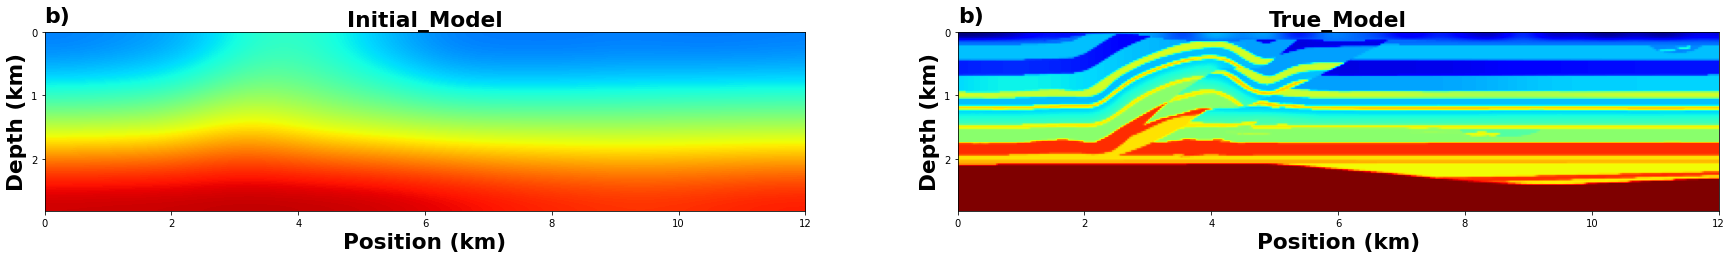

In [5]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3])
box_min = 2360
box_max = 6000

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx1 / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx1 / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [6]:
from torchsummary import summary
from Model.Module22 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2


### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(1,nt,num_receivers_per_shot),(1,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 565
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1, 2000, 567]              10
         LeakyReLU-2         [-1, 1, 2000, 567]               0
            Conv2d-3         [-1, 2, 2000, 567]              20
         LeakyReLU-4         [-1, 2, 2000, 567]               0
            Conv2d-5         [-1, 2, 2000, 567]              20
         LeakyReLU-6         [-1, 2, 2000, 567]               0
            Conv2d-7         [-1, 4, 2000, 567]              40
         LeakyReLU-8         [-1, 4, 2000, 567]               0
            Conv2d-9         [-1, 4, 2000, 567]              40
        LeakyReLU-10         [-1, 4, 2000, 567]               0
           Conv2d-11         [-1, 2, 2000, 567]              20
        LeakyReLU-12         [-1, 2, 2000, 567]               0
           Conv2d-13         [-1, 1, 2000, 567]              10
        Leak

## Main SiameseFWI

In [8]:
 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR






t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)

        # Prepare the data for Siamese network.
        d_real = batch_rcv_amps_true.permute(1,0,2)
        d_real = d_real.unsqueeze(1)
        # train with fake data
        d_fake = batch_rcv_amps_pred.permute(1,0,2)
        d_fake = d_fake.unsqueeze(1)
        disc_fake, disc_real, o1, o2 = netD(d_fake,d_real)
        # Measure the Eculedian Loss.
        loss =   F.pairwise_distance(o1, o2, keepdim = True).mean()

        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 100 FWI iterations .
    #if (i>0) and (i%100==0):
    #    scheduler.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  0.2036917621890704 lr_DL: 0.0001 lr_vel: 80 SNR: 18.10200829611988 SSIM: 0.028737321
Epoch: 2 Loss:  0.18014706720908483 lr_DL: 0.0001 lr_vel: 80 SNR: 17.76579342912775 SSIM: 0.032513935
Epoch: 3 Loss:  0.16953086679180462 lr_DL: 0.0001 lr_vel: 80 SNR: 17.65139744558985 SSIM: 0.052314367
Epoch: 4 Loss:  0.1560403933127721 lr_DL: 0.0001 lr_vel: 80 SNR: 17.48098996568501 SSIM: 0.06267461
Epoch: 5 Loss:  0.14644793992241223 lr_DL: 0.0001 lr_vel: 80 SNR: 17.470339802693285 SSIM: 0.07582798
Epoch: 6 Loss:  0.1310779981315136 lr_DL: 0.0001 lr_vel: 80 SNR: 17.432258186965033 SSIM: 0.0824697
Epoch: 7 Loss:  0.11185746118426323 lr_DL: 0.0001 lr_vel: 80 SNR: 17.476110839712515 SSIM: 0.099169
Epoch: 8 Loss:  0.09099734698732694 lr_DL: 0.0001 lr_vel: 80 SNR: 17.555430124404985 SSIM: 0.106691256
Epoch: 9 Loss:  0.060707089677453044 lr_DL: 0.0001 lr_vel: 80 SNR: 17.52051869131465 SSIM: 0.11265321
Epoch: 10 Loss:  0.03326339609920979 lr_DL: 0.0001 lr_vel: 80 SNR: 17.535128468165762 SS

Epoch: 81 Loss:  0.0036703380290418865 lr_DL: 0.0001 lr_vel: 80 SNR: 21.503660952935096 SSIM: 0.45175686
Epoch: 82 Loss:  0.003252446752352019 lr_DL: 0.0001 lr_vel: 80 SNR: 21.586117952614675 SSIM: 0.45489553
Epoch: 83 Loss:  0.003149925312027335 lr_DL: 0.0001 lr_vel: 80 SNR: 21.65269171699935 SSIM: 0.45973617
Epoch: 84 Loss:  0.003145658290789773 lr_DL: 0.0001 lr_vel: 80 SNR: 21.723391717055254 SSIM: 0.46442372
Epoch: 85 Loss:  0.0033165232744067907 lr_DL: 0.0001 lr_vel: 80 SNR: 21.791122194622517 SSIM: 0.46777812
Epoch: 86 Loss:  0.0031706429552286865 lr_DL: 0.0001 lr_vel: 80 SNR: 21.85739584172975 SSIM: 0.47144702
Epoch: 87 Loss:  0.002834254417878886 lr_DL: 0.0001 lr_vel: 80 SNR: 21.92320484409658 SSIM: 0.47661132
Epoch: 88 Loss:  0.002953031515547385 lr_DL: 0.0001 lr_vel: 80 SNR: 21.984494175732912 SSIM: 0.48010364
Epoch: 89 Loss:  0.0029883032858682174 lr_DL: 0.0001 lr_vel: 80 SNR: 22.068803028467183 SSIM: 0.48420462
Epoch: 90 Loss:  0.002821777353528887 lr_DL: 0.0001 lr_vel: 80 

Epoch: 160 Loss:  0.0006025369317891697 lr_DL: 0.0001 lr_vel: 80 SNR: 24.62185688806081 SSIM: 0.6332443
Epoch: 161 Loss:  0.0006285248760832474 lr_DL: 0.0001 lr_vel: 80 SNR: 24.639122209897653 SSIM: 0.6342701
Epoch: 162 Loss:  0.0006045391724910587 lr_DL: 0.0001 lr_vel: 80 SNR: 24.658223928882293 SSIM: 0.6346875
Epoch: 163 Loss:  0.0006084333018710216 lr_DL: 0.0001 lr_vel: 80 SNR: 24.667888541887844 SSIM: 0.6359163
Epoch: 164 Loss:  0.0005345797806512564 lr_DL: 0.0001 lr_vel: 80 SNR: 24.6861369723681 SSIM: 0.6366932
Epoch: 165 Loss:  0.0005491528863785788 lr_DL: 0.0001 lr_vel: 80 SNR: 24.695387778779534 SSIM: 0.6375654
Epoch: 166 Loss:  0.0005096873200576131 lr_DL: 0.0001 lr_vel: 80 SNR: 24.71176585151643 SSIM: 0.63901585
Epoch: 167 Loss:  0.000493935847771354 lr_DL: 0.0001 lr_vel: 80 SNR: 24.72216897152244 SSIM: 0.6396185
Epoch: 168 Loss:  0.000499206757134137 lr_DL: 0.0001 lr_vel: 80 SNR: 24.73837826350071 SSIM: 0.6401021
Epoch: 169 Loss:  0.0005181139926814164 lr_DL: 0.0001 lr_vel: 

Epoch: 238 Loss:  0.00027434446528786796 lr_DL: 0.0001 lr_vel: 80 SNR: 25.48887914449676 SSIM: 0.6782504
Epoch: 239 Loss:  0.00017731824167033968 lr_DL: 0.0001 lr_vel: 80 SNR: 25.503600538237492 SSIM: 0.6789685
Epoch: 240 Loss:  0.00016798319265944883 lr_DL: 0.0001 lr_vel: 80 SNR: 25.51299988554382 SSIM: 0.6793991
Epoch: 241 Loss:  0.0001541554243885912 lr_DL: 0.0001 lr_vel: 80 SNR: 25.52067212362465 SSIM: 0.67993903
Epoch: 242 Loss:  0.00016288792442840835 lr_DL: 0.0001 lr_vel: 80 SNR: 25.52876762470315 SSIM: 0.6799529
Epoch: 243 Loss:  0.00015976670183590614 lr_DL: 0.0001 lr_vel: 80 SNR: 25.538874251703675 SSIM: 0.6802345
Epoch: 244 Loss:  0.00015226642208290286 lr_DL: 0.0001 lr_vel: 80 SNR: 25.546590993758656 SSIM: 0.68081254
Epoch: 245 Loss:  0.0001757252830429934 lr_DL: 0.0001 lr_vel: 80 SNR: 25.54957427398883 SSIM: 0.6807129
Epoch: 246 Loss:  0.00017652828731418898 lr_DL: 0.0001 lr_vel: 80 SNR: 25.559372409000055 SSIM: 0.68113166
Epoch: 247 Loss:  0.0001617952732582732 lr_DL: 0.0

Epoch: 316 Loss:  0.00015286199438075226 lr_DL: 0.0001 lr_vel: 80 SNR: 25.99204037875033 SSIM: 0.6946988
Epoch: 317 Loss:  0.00014293437998276205 lr_DL: 0.0001 lr_vel: 80 SNR: 25.995930545905487 SSIM: 0.69472665
Epoch: 318 Loss:  0.0001382066824589856 lr_DL: 0.0001 lr_vel: 80 SNR: 26.001943872839114 SSIM: 0.695061
Epoch: 319 Loss:  0.00013475326219728837 lr_DL: 0.0001 lr_vel: 80 SNR: 26.005077081770555 SSIM: 0.69513553
Epoch: 320 Loss:  0.0001401121238207755 lr_DL: 0.0001 lr_vel: 80 SNR: 26.009730604891462 SSIM: 0.69532955
Epoch: 321 Loss:  0.0001379470406391192 lr_DL: 0.0001 lr_vel: 80 SNR: 26.01715196186579 SSIM: 0.69538885
Epoch: 322 Loss:  0.00012994125669744486 lr_DL: 0.0001 lr_vel: 80 SNR: 26.02384020758061 SSIM: 0.6955893
Epoch: 323 Loss:  0.00012542918581554357 lr_DL: 0.0001 lr_vel: 80 SNR: 26.02819483882761 SSIM: 0.6957054
Epoch: 324 Loss:  0.00015017100959084927 lr_DL: 0.0001 lr_vel: 80 SNR: 26.029435291542985 SSIM: 0.695316
Epoch: 325 Loss:  0.00013673645905024992 lr_DL: 0.0

Epoch: 394 Loss:  0.00013147129623879058 lr_DL: 0.0001 lr_vel: 80 SNR: 26.32966642788122 SSIM: 0.70307827
Epoch: 395 Loss:  0.00011049967724829912 lr_DL: 0.0001 lr_vel: 80 SNR: 26.335344763221478 SSIM: 0.7032532
Epoch: 396 Loss:  0.00010976581543218345 lr_DL: 0.0001 lr_vel: 80 SNR: 26.339189814317034 SSIM: 0.7034402
Epoch: 397 Loss:  0.000126678372665386 lr_DL: 0.0001 lr_vel: 80 SNR: 26.338536839838795 SSIM: 0.7033098
Epoch: 398 Loss:  0.00012947987949398035 lr_DL: 0.0001 lr_vel: 80 SNR: 26.345364270422927 SSIM: 0.703323
Epoch: 399 Loss:  0.00014302340835759726 lr_DL: 0.0001 lr_vel: 80 SNR: 26.350040694289106 SSIM: 0.7036028
Epoch: 400 Loss:  0.00011355293900123797 lr_DL: 0.0001 lr_vel: 80 SNR: 26.356434689634376 SSIM: 0.7037256
Epoch: 401 Loss:  0.00011603214855616291 lr_DL: 0.0001 lr_vel: 80 SNR: 26.36019833964733 SSIM: 0.70385885
Epoch: 402 Loss:  0.00011562269501155242 lr_DL: 0.0001 lr_vel: 80 SNR: 26.363400626782916 SSIM: 0.70397455
Epoch: 403 Loss:  0.00012070833060230749 lr_DL: 

Epoch: 472 Loss:  9.727199964496928e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.59599558552491 SSIM: 0.7095356
Epoch: 473 Loss:  0.00010673023255852362 lr_DL: 0.0001 lr_vel: 80 SNR: 26.597254168451933 SSIM: 0.7096582
Epoch: 474 Loss:  0.00010654703558733066 lr_DL: 0.0001 lr_vel: 80 SNR: 26.60284185020487 SSIM: 0.7096947
Epoch: 475 Loss:  9.896958727040328e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.607799688363517 SSIM: 0.70979136
Epoch: 476 Loss:  0.00010479939010110684 lr_DL: 0.0001 lr_vel: 80 SNR: 26.608856298359523 SSIM: 0.709825
Epoch: 477 Loss:  0.00010933563510964936 lr_DL: 0.0001 lr_vel: 80 SNR: 26.612276942844282 SSIM: 0.7099907
Epoch: 478 Loss:  0.00010526435895978163 lr_DL: 0.0001 lr_vel: 80 SNR: 26.61533694413512 SSIM: 0.7099441
Epoch: 479 Loss:  0.00011222164272718752 lr_DL: 0.0001 lr_vel: 80 SNR: 26.612741706214763 SSIM: 0.7099543
Epoch: 480 Loss:  0.00012222026780364103 lr_DL: 0.0001 lr_vel: 80 SNR: 26.61913291525289 SSIM: 0.71008074
Epoch: 481 Loss:  0.0001026469915814232 lr_DL: 0.00

Epoch: 550 Loss:  0.00013997893450626482 lr_DL: 0.0001 lr_vel: 80 SNR: 26.813170988910855 SSIM: 0.71544665
Epoch: 551 Loss:  0.00019561708565258112 lr_DL: 0.0001 lr_vel: 80 SNR: 26.80895092879409 SSIM: 0.7149958
Epoch: 552 Loss:  9.447390305770872e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.818892522227713 SSIM: 0.71542996
Epoch: 553 Loss:  8.260803551820572e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.82318675494846 SSIM: 0.71582896
Epoch: 554 Loss:  8.15626809829458e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.827742684055487 SSIM: 0.71593326
Epoch: 555 Loss:  8.350493480975274e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.82920882038079 SSIM: 0.7160467
Epoch: 556 Loss:  7.87415786665709e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.83284721147134 SSIM: 0.7162022
Epoch: 557 Loss:  7.918998768824773e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.83561490066577 SSIM: 0.7162771
Epoch: 558 Loss:  7.978440577668758e-05 lr_DL: 0.0001 lr_vel: 80 SNR: 26.840185929530172 SSIM: 0.71644104
Epoch: 559 Loss:  8.308339553574721e-05 lr_DL: 0.0001 l

## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


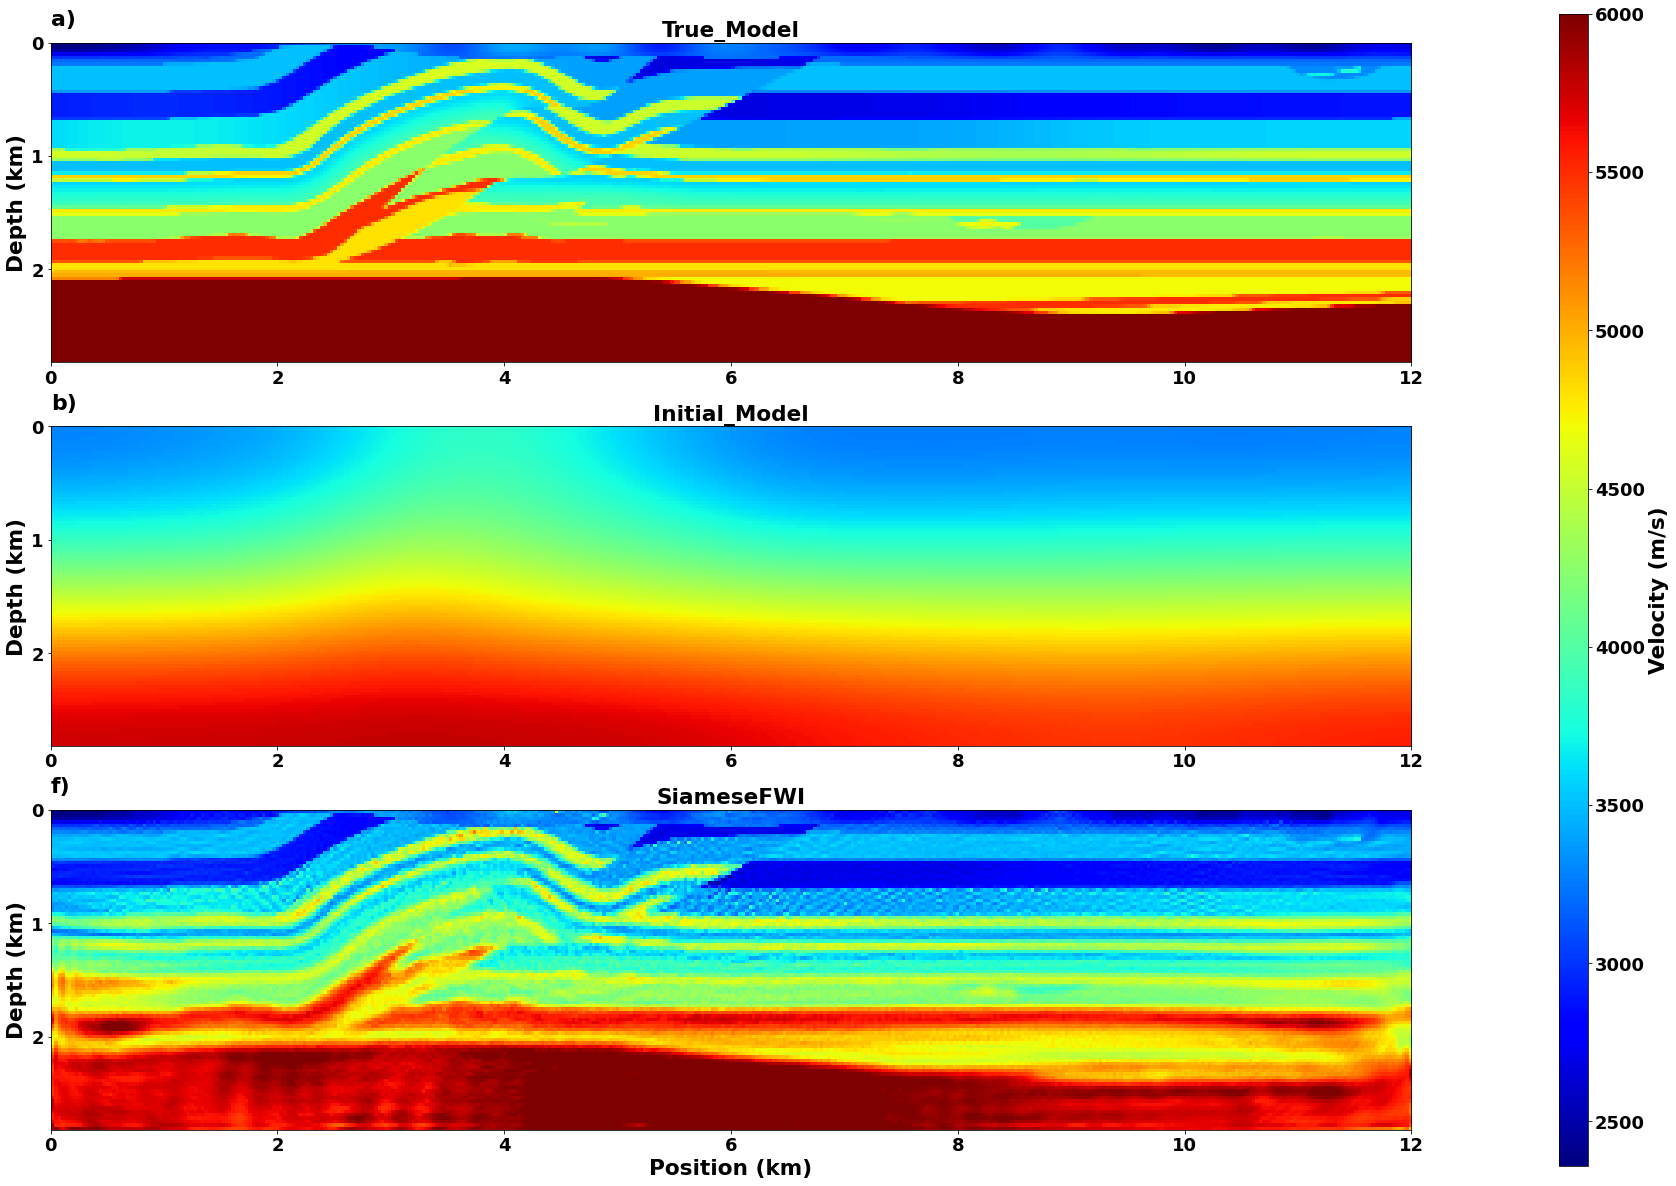

The reconstructed velocity model has SNR: 26.9419022170627 dB and SSIM: 0.7203856


In [9]:

f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx1 / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx1 / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx1 / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

## Plotting Velocities Profiles

In [14]:
#torch.save(netD.state_dict(), fwi_result + 'netD')
#netD = torch.load(fwi_result + 'netD')
#netD